# Shor's Algorithm (Adapted from Qiskit Textbook) 
https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/shor.ipynb

## 1: imports

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

# pylint: disable=invalid-name
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

print("Imports Successful")

Imports Successful


## 2: Building the circuits for shor's algorithm
 

In [2]:
# Specify variables
N_COUNT = 3  # number of counting qubits
a = 7
U_COUNT = 4
N=11

In [3]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(U_COUNT)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

## 3: implementing the quantum fourier transform

In [4]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi / float(2 ** (j - m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

## 4: Building the circuit

In [5]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + U_COUNT, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(U_COUNT)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

┌───┐                                             ┌───────┐┌─┐      
q_0: ┤ H ├───────■─────────────────────────────────────┤0      ├┤M├──────
     ├───┤       │                                     │       │└╥┘┌─┐   
q_1: ┤ H ├───────┼──────────────■──────────────────────┤1 QFT† ├─╫─┤M├───
     ├───┤       │              │                      │       │ ║ └╥┘┌─┐
q_2: ┤ H ├───────┼──────────────┼──────────────■───────┤2      ├─╫──╫─┤M├
     ├───┤┌──────┴──────┐┌──────┴──────┐┌──────┴──────┐└───────┘ ║  ║ └╥┘
q_3: ┤ X ├┤0            ├┤0            ├┤0            ├──────────╫──╫──╫─
     └───┘│             ││             ││             │          ║  ║  ║ 
q_4: ─────┤1            ├┤1            ├┤1            ├──────────╫──╫──╫─
          │  7^1 mod 15 ││  7^2 mod 15 ││  7^4 mod 15 │          ║  ║  ║ 
q_5: ─────┤2            ├┤2            ├┤2            ├──────────╫──╫──╫─
          │             ││             ││             │          ║  ║  ║ 
q_6: ─────┤3            ├┤3            ├┤3            ├──────────╫──╫──╫─
          └─────────────┘└─────────────┘└─────────────┘          ║  ║  ║ 
c: 3/════════════════════════════════════════════════════════════╩══╩══╩═
                                                                 0  1  2

## 5: Running on simulator:

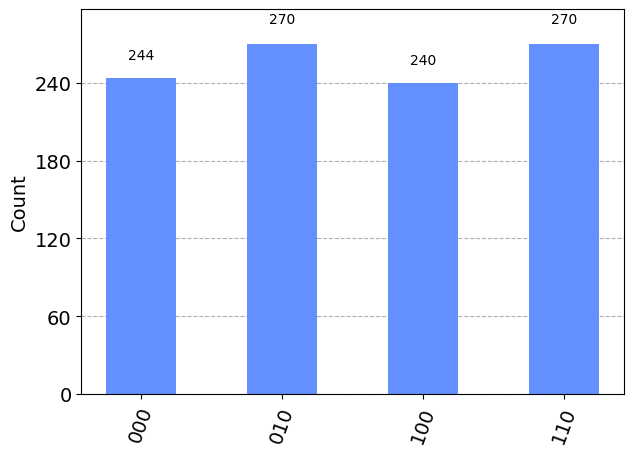

In [6]:
backend = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, backend)
counts = backend.run(t_qc).result().get_counts()
plot_histogram(counts)

In [7]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Register Output       Phase
0  110(bin) =   6(dec)  6/8 = 0.75
1  000(bin) =   0(dec)  0/8 = 0.00
2  010(bin) =   2(dec)  2/8 = 0.25
3  100(bin) =   4(dec)  4/8 = 0.50


In [8]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.00      0/1            1
2   0.25      1/4            4
3   0.50      1/2            2


# Setting up real quantum hardware

### getting API Object

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum", token="YOUR-PERSONAL-ACCESS-TOKEN")
# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)


### converting circuit to ISA

In [10]:
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)
isa_circuit.draw('mpl', idle_wires=False)
print ("Circuit converted to ISA successfully")

Circuit converted to ISA successfully


### Creating the Estimator

In [11]:
# Construct the Estimator instance we want to use.

# Set up observables for each qubit
observables_labels = ["Z"*7 for _ in range(N_COUNT + U_COUNT)]
observables = [SparsePauliOp(label) for label in observables_labels]

observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

estimator = Estimator(backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 500


### Run the circuits

In [12]:
job = estimator.run([(isa_circuit, observables)])
job_result = job.result()
pub_result = job.result()[0]

D:\Documents\Code\jetbrains\pycharm\quantumTesting\.venv\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:879: UserWarning: Your current pending jobs are estimated to consume 623.1034379365619 quantum seconds, but you only have 600 quantum seconds left in your monthly quota; therefore, it is likely this job will be canceled
  warnings.warn(warning_message)


In [44]:
r = pub_result.data.evs[0]
print (r)

-0.030418250950570342


In [45]:
if int(r) % 2 != 0 or pow(a, int(r) // 2, N) == N - 1:
    print("Failed to find a nontrivial factor, try again with a different random number a")
else:
    factor1 = gcd(pow(a, int(r) // 2) - 1, N)
    factor2 = gcd(pow(a, int(r) // 2) + 1, N)
    print(f"The factors of {N} are {factor1} and {factor2}")

The factors of 11 are 11 and 1
